## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` (Shown) 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 1`: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use Open Clip multi-modal embeddings.
* We will use [Chroma](https://www.trychroma.com/) with support for multi-modal.

A seperate cookbook highlights `Options 2 and 3` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG.ipynb).

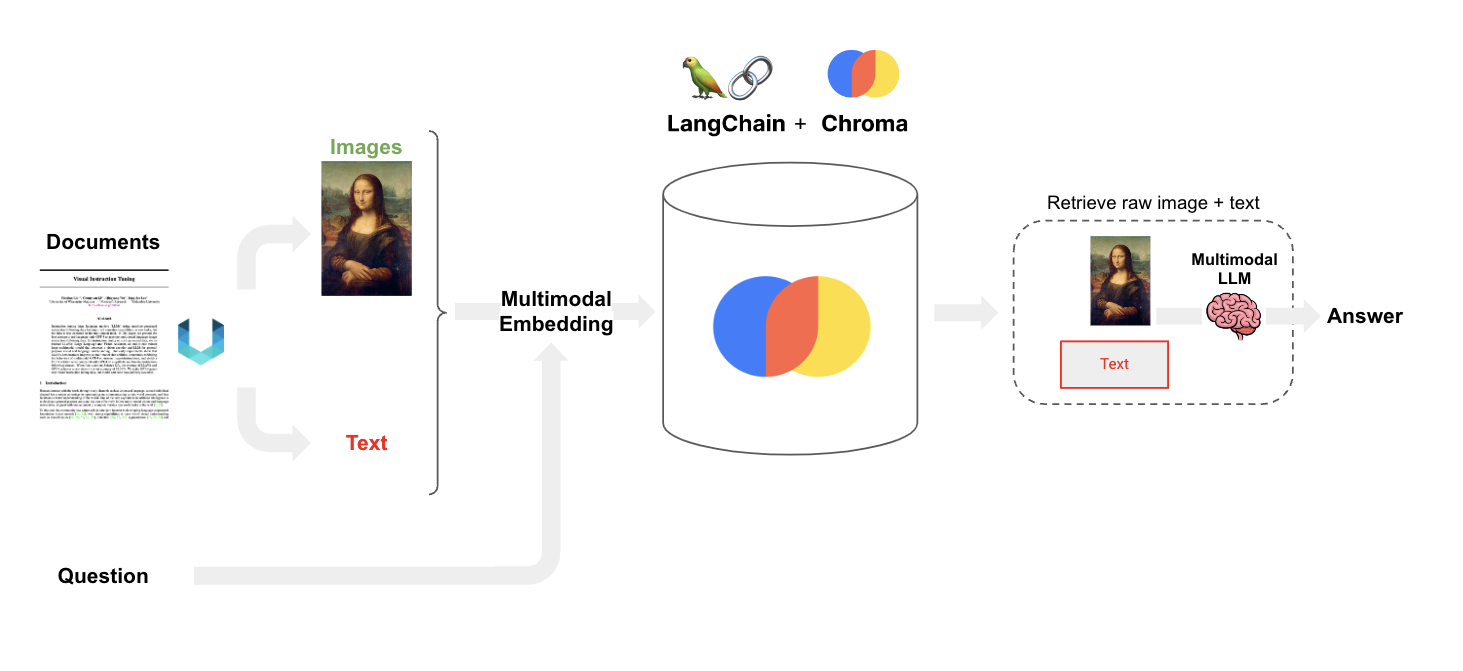

## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install "langchain==0.0.331rc2" # (required for multi-modal)
! pip install "openai==1.1.1" # (required for multi-modal)
! pip install "chromadb==0.4.16" # (required for multi-modal)

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdf of classical [Art](https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf) from the J Paul Getty museum.

In [2]:
path = "/Users/rlm/Desktop/art/"

In [ ]:
from unstructured.partition.pdf import partition_pdf
# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "getty.pdf",
    extract_images_in_pdf=True, 
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [5]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set [here](https://github.com/langchain-ai/langchain/blob/ff43cd67017ef3311d300b61eeedf52b917d02bf/libs/langchain/langchain/embeddings/open_clip.py#L20)).

```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

In [9]:
import os
import uuid
import chromadb
import numpy as np
from PIL import Image as _PILImage
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenCLIPEmbeddings

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_test",
    embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(path, image_name) 
                     for image_name in os.listdir(path) 
                     if image_name.endswith('.jpg')])

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever 
retriever = vectorstore.as_retriever()

Test


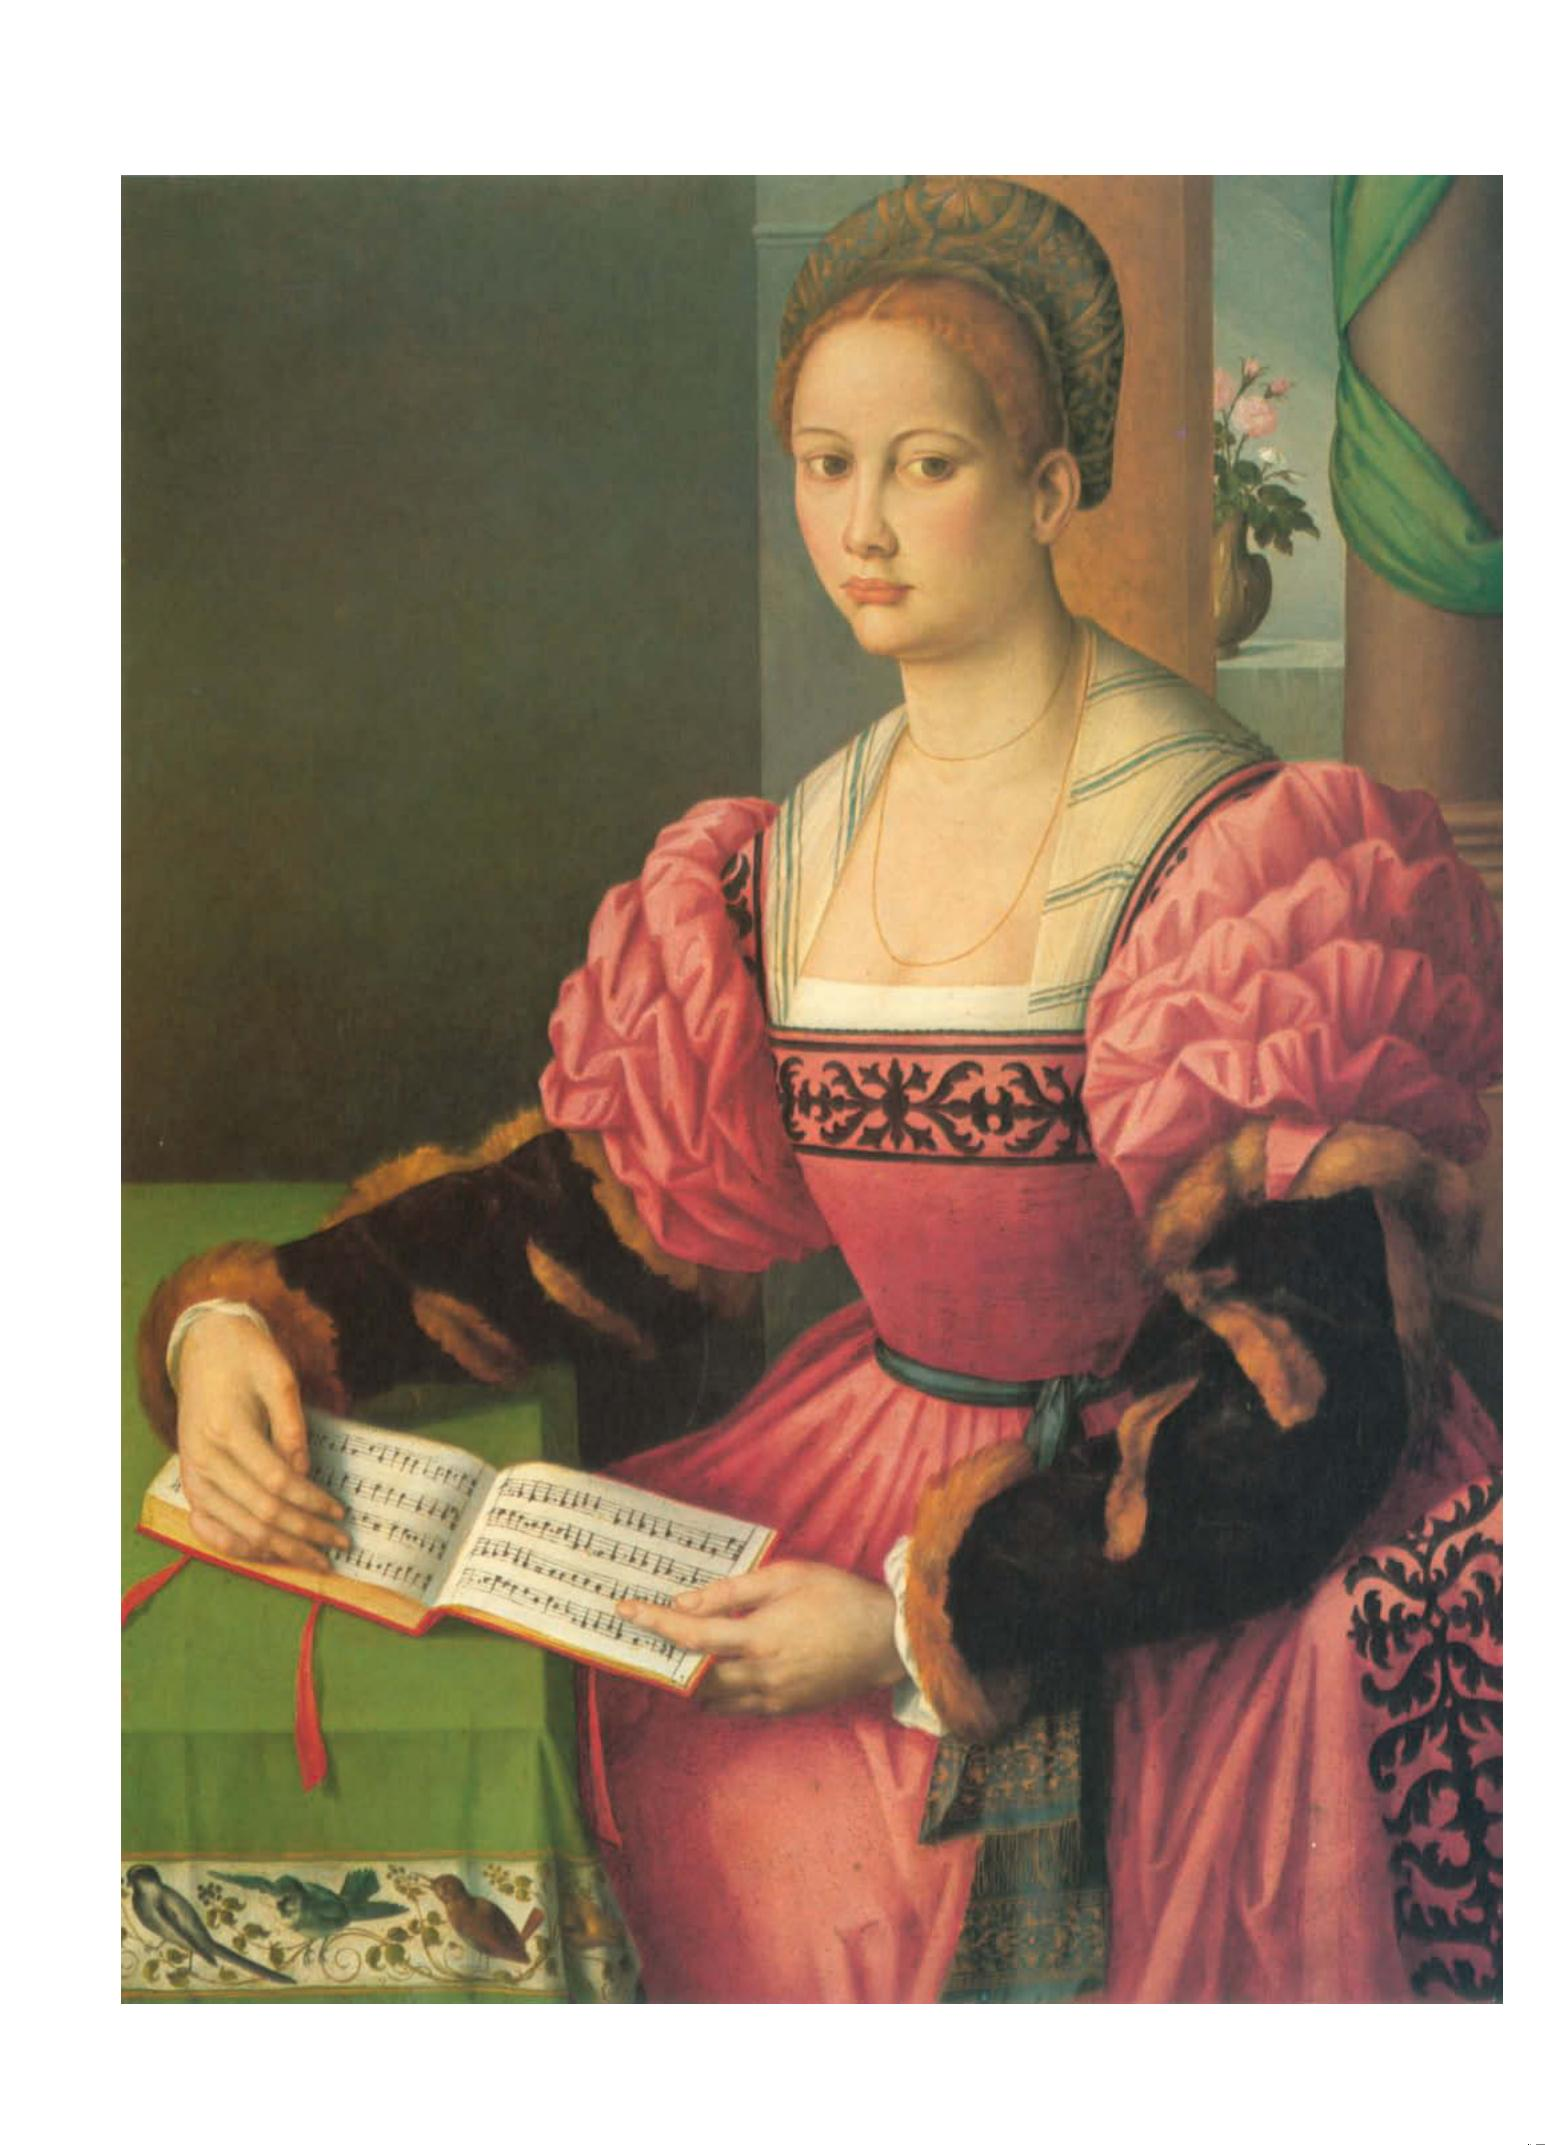

In [28]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    
    # Display the image by rendering the HTML
    display(HTML(image_html))

query = "Art featuring a woman sitting"
docs = retriever.get_relevant_documents(query,k=5)
plt_img_base64(docs[1].page_content)


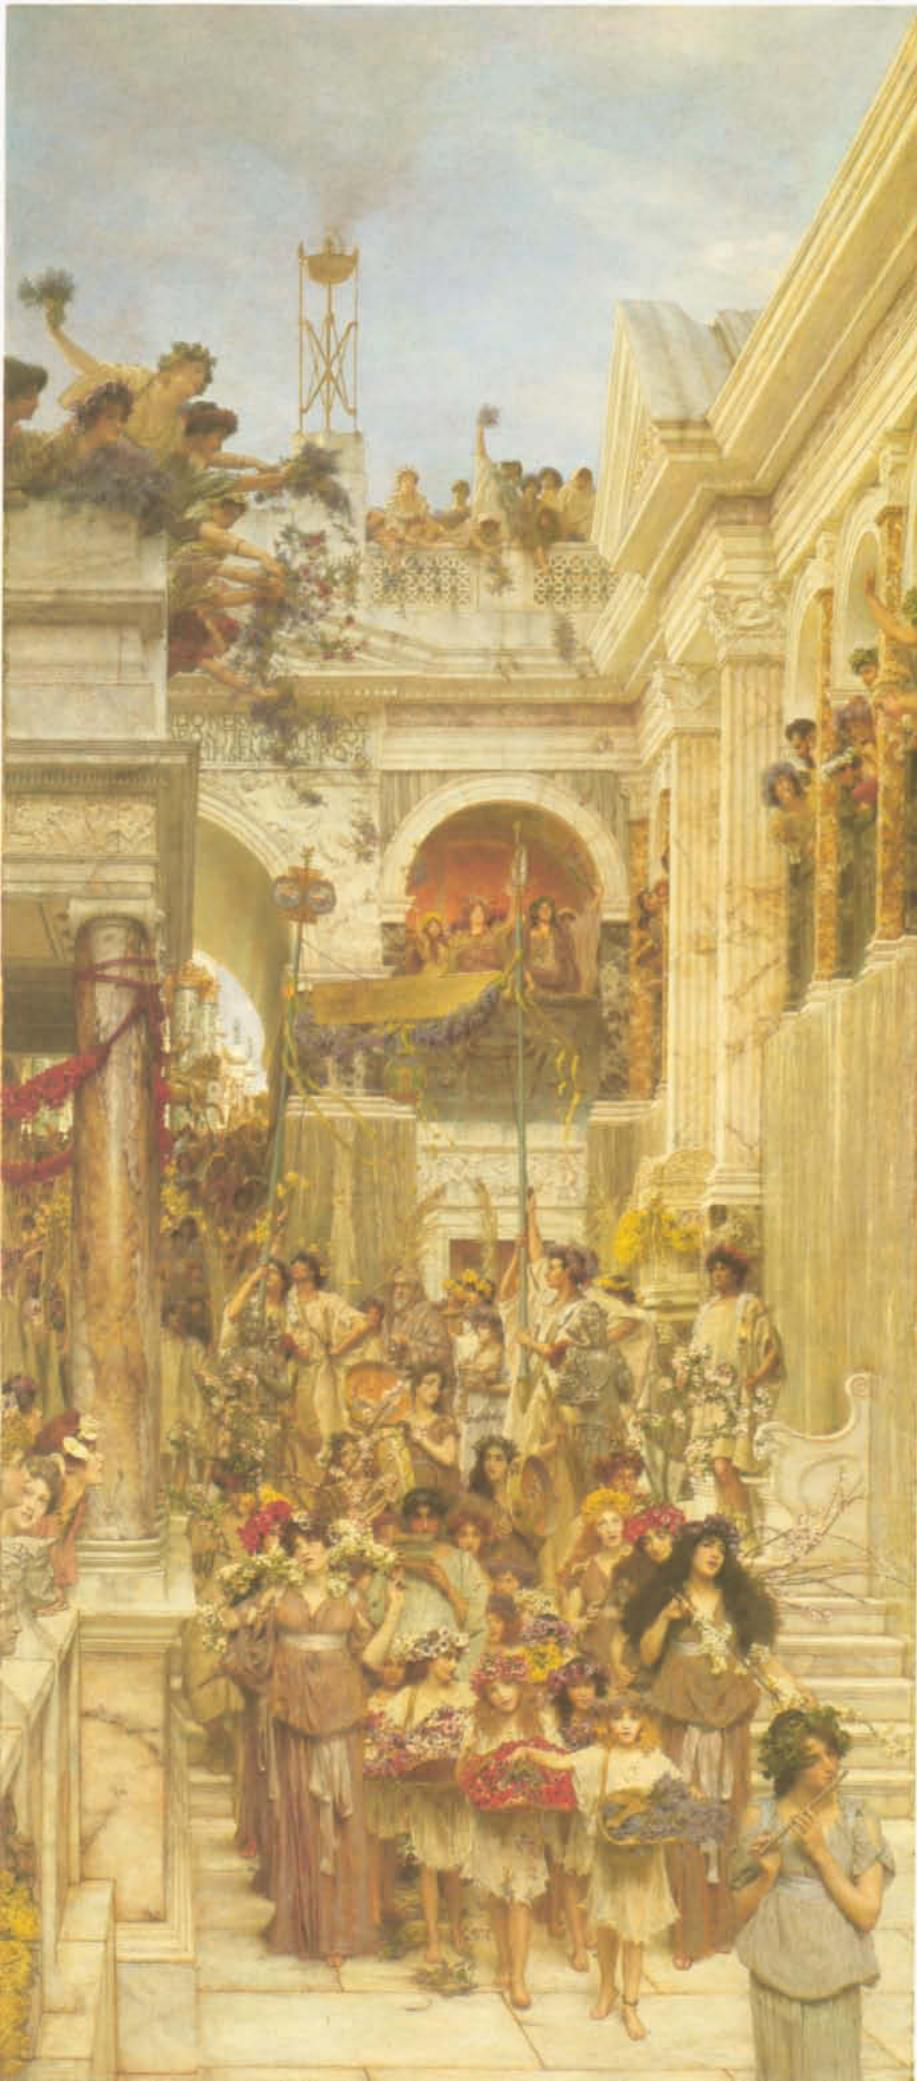

In [32]:
query = "Art featuring a Romain scene, arches"
docs = retriever.get_relevant_documents(query,k=5)
plt_img_base64(docs[2].page_content)

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

These can be passed to GPT-4V.

In [40]:
import numpy as np
import base64
from io import BytesIO
from PIL import Image

def is_base64(s):
    ''' Check if a string is Base64 encoded '''
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False
        
def split_image_text_types(docs):
    ''' Split numpy array images and texts '''
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content # Extract Document contents 
        if is_base64(doc):
            images.append(doc)  # base64 encoded str 
        else:
            text.append(doc) 
    return {
        "images": images,
        "texts": text
    }

## RAG

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [42]:
from operator import itemgetter
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema.messages import HumanMessage, SystemMessage

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    messages = [
        {"type": "text", "text": f"""You are an art critic. Descrive and discuss art using following context, which can include text and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
"""}]

    if dict["context"]["images"]:  # Check if there are any images
        image_message = {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}}
        messages.append(image_message)

    return [HumanMessage(content=messages)]
    
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [43]:
chain.invoke(
    "Art featuring a Romain scene, arches"
)

"The image presented here is a rich tapestry of classical Roman life, depicted with a romanticized vision that is characteristic of certain artistic periods that sought to evoke the grandeur and beauty of antiquity. The scene is bustling with activity, as figures adorned with floral wreaths and garlands engage in what appears to be a festive procession or celebration. The architecture surrounding them is replete with classical Roman elements, including arches, columns, and intricate friezes, which lend an air of authenticity and historical context to the composition.\n\nThe artist has skillfully employed a soft, diffused light that bathes the scene in a warm, golden hue, suggesting the glow of late afternoon. This lighting choice enhances the sense of nostalgia and romanticism that pervades the work. The use of shadows and the varying intensity of light and color across the canvas create a dynamic and engaging visual experience, drawing the viewer's eye through the different levels of 

LangSmith [trace](https://smith.langchain.com/public/e0b03a98-e859-48ff-8aee-761c27bd987a/r).

In [85]:
chain.invoke(
    "War"
)

"The image you've provided appears to be a historical painting depicting a scene that could be interpreted as a moment of truce or negotiation during a time of conflict. The central figures are engaged in a handshake, which is often a symbol of agreement or peace. The presence of military attire, such as armor and weapons, suggests that the individuals are of high rank and possibly commanders or nobility who have the authority to negotiate terms.\n\nThe painting is executed with a focus on realism, capturing the textures of the fabrics, the shine of the armor, and the individual expressions of the characters. The use of chiaroscuro, the contrast between light and dark, adds depth to the scene and highlights the central action of the handshake. The background is less detailed, which is typical of many historical paintings, where the emphasis is on the subjects and their interactions rather than the setting.\n\nIn the context of war, this painting could be seen as a representation of the

LangSmith [trace](https://smith.langchain.com/public/a7c45b37-0576-47c3-beeb-7b2cb610a51b/r).